# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

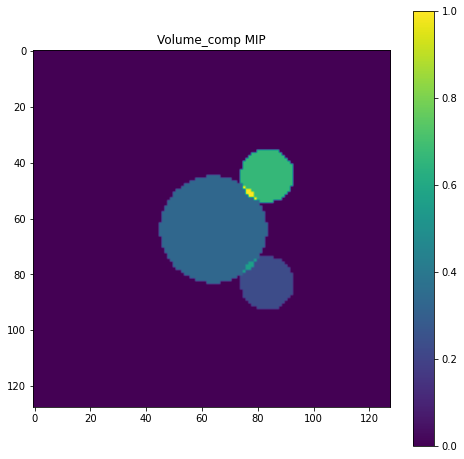

In [3]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

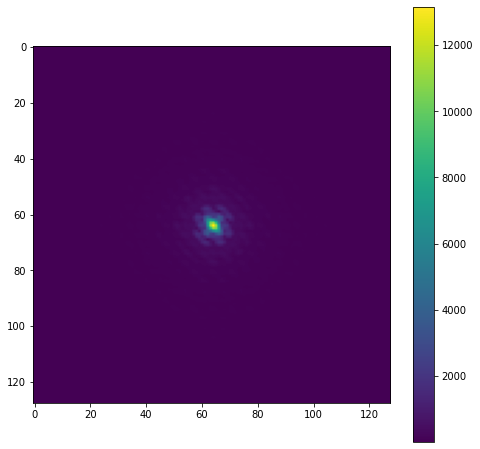

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [5]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

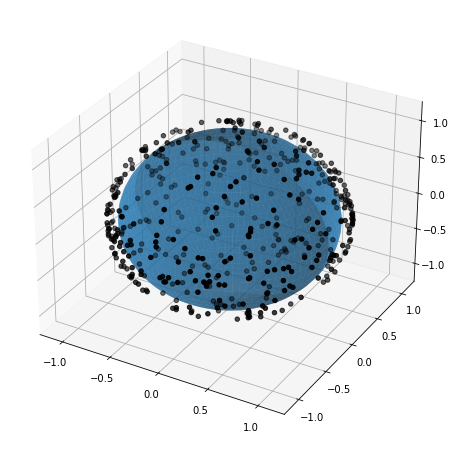

In [192]:
# Orientations
N = 10000

#s = 0.05
s = 0.1
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [193]:
angles_true.shape

(10000, 3)

2.455773115158081
0.41448276793317146


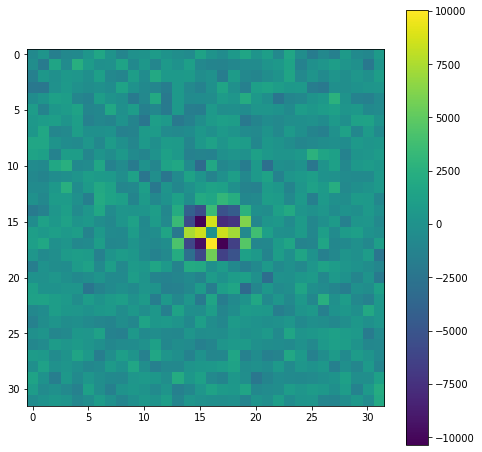

In [194]:
radius = 10
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [195]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32
imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
imgs = imgs.reshape(imgs.shape[0], nx*nx)

vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

y_grid = x_grid
z_grid = x_grid

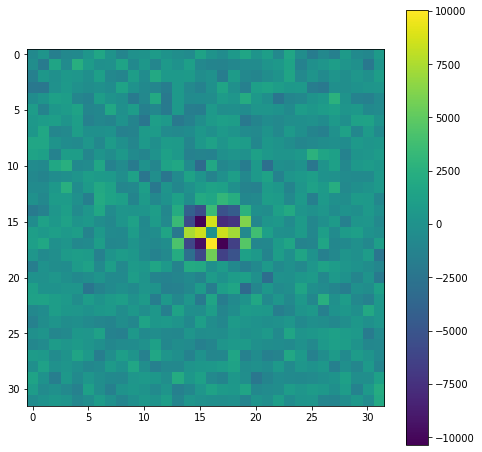

In [196]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

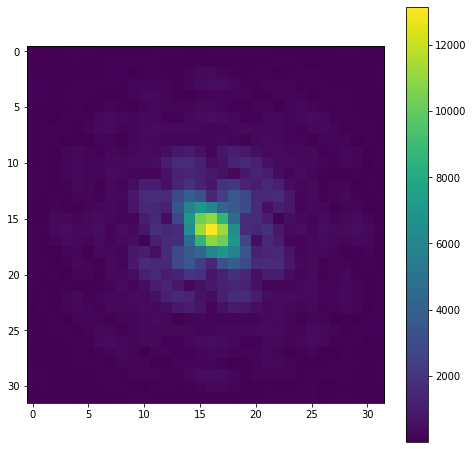

In [197]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

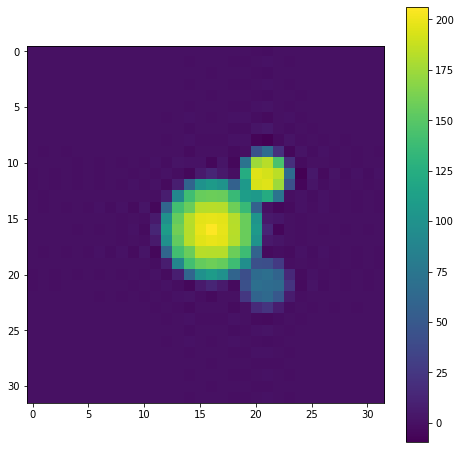

In [198]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

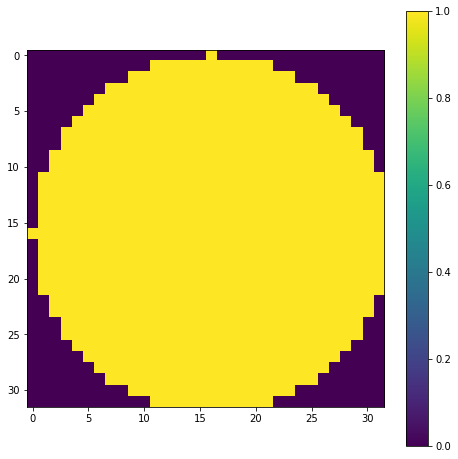

In [199]:
alpha = 0.01

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [200]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.2293400764465332
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [201]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.2529737949371338
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [202]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.3964993953704834
(32, 32, 32)


## Orientations

In [203]:
#loss_func_sum_angles = jax.vmap(loss_func_sum, in_axes=(None, 0, None, None, None))
loss_func_angles = jax.jit(jax.vmap(loss_func, in_axes = (None, 0, None, None, None)))

In [204]:
def sample_new_angles_one_img(loss_func_angles, vol, shifts_true, ctf_params, img, N_samples):
    ang_samples = generate_uniform_orientations(N_samples)
    loss = loss_func_angles(vol, ang_samples, shifts_true, ctf_params, img)
    li = jnp.argmin(loss)
    return ang_samples[li]

In [205]:
sample_new_angles_vmap = jax.vmap(sample_new_angles_one_img, in_axes = (None, None, 0, 0, 0, None))

In [206]:
def sample_new_angles(loss_func_angles, vol, shifts_true, ctf_params, imgs, N_samples):
    angles = []
    for ai in range(N):
        ang_samples = generate_uniform_orientations(N_samples)
        loss = loss_func_angles(vol, ang_samples, shifts_true[ai], ctf_params[ai], imgs[ai])
        li = jnp.argmin(loss)
        angles.append(ang_samples[li])
    return jnp.array(angles)    

In [207]:

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
vcg = v0
loss_min = jnp.inf
loss = jnp.inf * jnp.ones(N_samples)
li = 0

N_samples = 1000
N_iter = 10
N_cg_iter = 100
dr = 0.05
radius = 0.05



In [208]:
angles.shape

(5000, 3)

In [209]:
angles = generate_uniform_orientations(N)

AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts_true, ctf_params, imgs, v0.shape)
vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
    

Iter 0 ||r|| = 2.269031100469961
Iter 50 ||r|| = 0.0022097270815261403


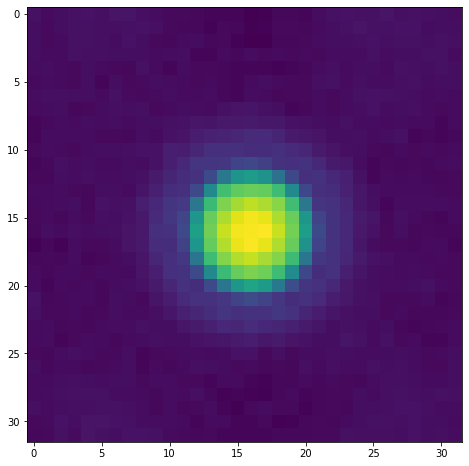

In [210]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:]))))

Iter  0
angles loss 258890.8929003274
Iter 0 ||r|| = 4.186440727406083
Iter 50 ||r|| = 0.0022027428429558624


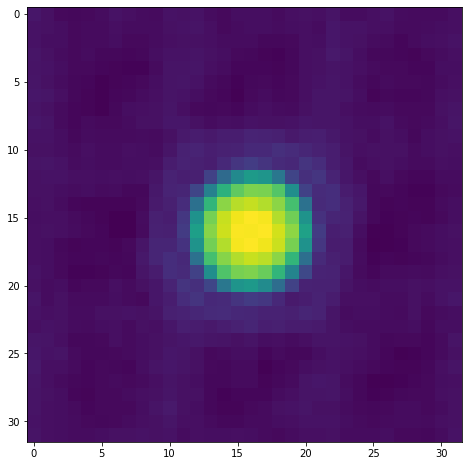

Iter  1
angles loss 84438.9401273849
Iter 0 ||r|| = 4.270998203236262
Iter 50 ||r|| = 0.0012305688536507573


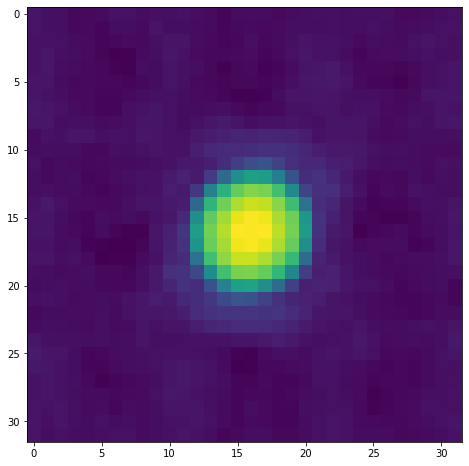

Iter  2
angles loss 33439.00089967936
Iter 0 ||r|| = 4.509393434899198
Iter 50 ||r|| = 0.0026811109751451513


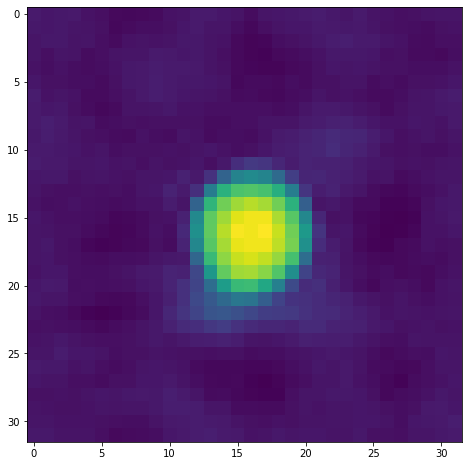

Iter  3
angles loss 19007.798208006694
Iter 0 ||r|| = 4.083011951557218
Iter 50 ||r|| = 0.002303389992341049


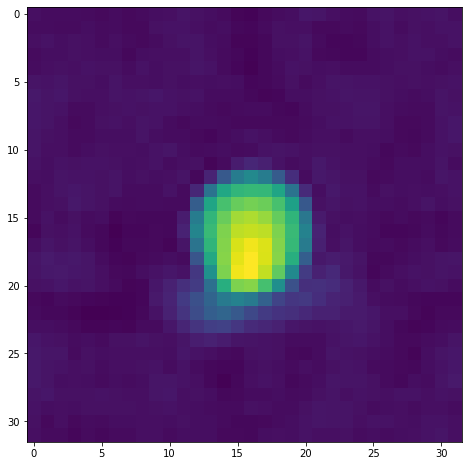

Iter  4
angles loss 11310.749054218302
Iter 0 ||r|| = 4.089160124993911
Iter 50 ||r|| = 0.0033058746879889482


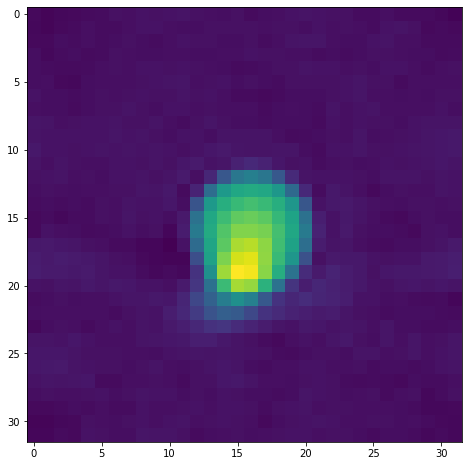

Iter  5
angles loss 8313.659989766546
Iter 0 ||r|| = 4.157386649844338
Iter 50 ||r|| = 0.002405989655575708


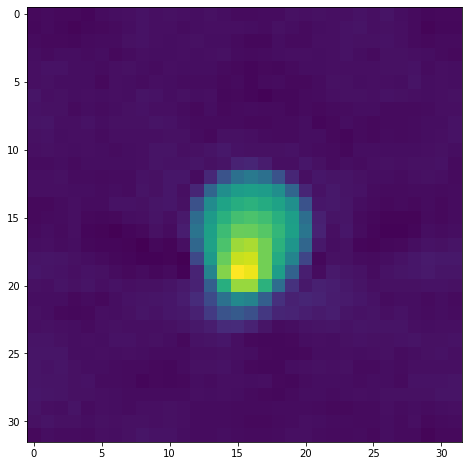

Iter  6
angles loss 6202.929269315836
Iter 0 ||r|| = 4.09885619837787
Iter 50 ||r|| = 0.002165000599101698


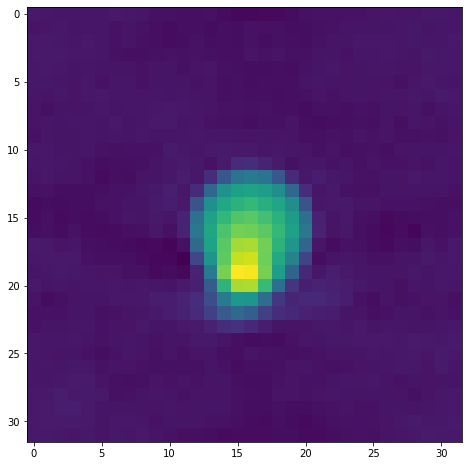

Iter  7
angles loss 4637.274885964353
Iter 0 ||r|| = 4.097288580604936
Iter 50 ||r|| = 0.0026861887013494967


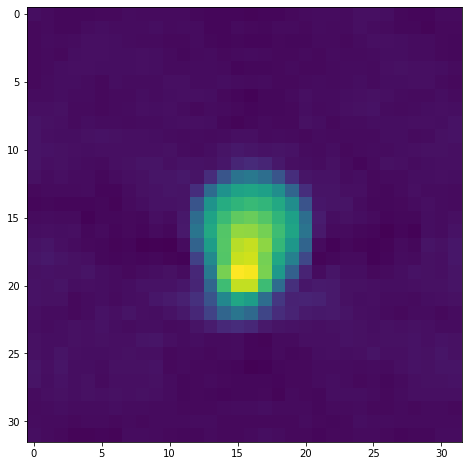

Iter  8
angles loss 3596.1280293539685
Iter 0 ||r|| = 4.071740145799488
Iter 50 ||r|| = 0.002924741470151805


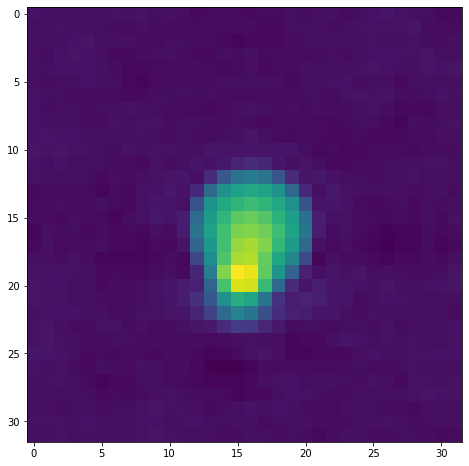

Iter  9
angles loss 2925.960619873394
Iter 0 ||r|| = 4.046793652468465
Iter 50 ||r|| = 0.0020145251757442135


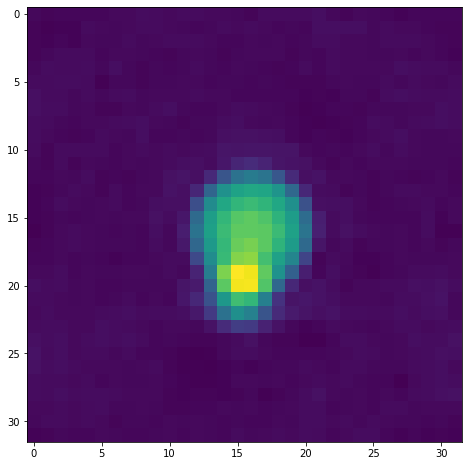

In [211]:

for idx in range(N_iter):
    print("Iter ", idx)
    
    mask3d = create_3d_mask(x_grid, (0,0,0),radius)
    mask2d = mask3d[0].reshape(1,-1)
    
    #while loss[li] >= loss_min:
    #    angles = jnp.array(np.random.rand(N_samples,N,3))
    #    #loss = loss_func_sum_angles(vcg*mask3d, angles, shifts_true, ctf_params, imgs*mask2d)/jnp.sum(mask2d)
    #    
    #    loss = jnp.array([loss_func_sum(vcg*mask3d, ang, shifts_true, ctf_params, imgs*mask2d) for ang in angles])/jnp.sum(mask2d)
    #    
    #    li = jnp.argmin(loss)
    

    #angles = sample_new_angles(loss_func_angles, shifts_true, ctf_params, imgs, 50)    
    angles = sample_new_angles_vmap(loss_func_angles, vcg*mask3d, shifts_true, ctf_params, imgs*mask2d, N_samples)    

     
    loss_min = loss_func_sum(vcg*mask3d, angles, shifts_true, ctf_params, imgs)/jnp.sum(mask2d)
    print("angles loss", loss_min)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts_true, ctf_params, imgs, v0.shape)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
    
    radius += dr
    
    #plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0])*mask2d.reshape(32,32))))
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0]))))
    plt.show()

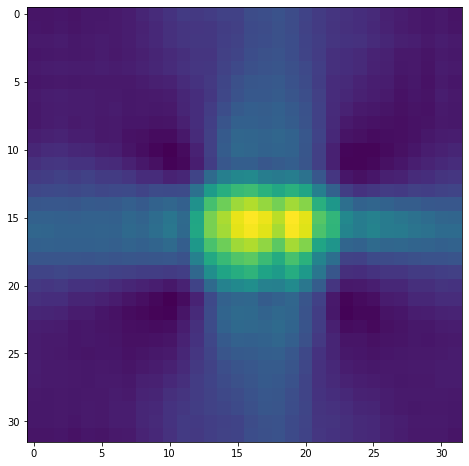

In [218]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:]))))



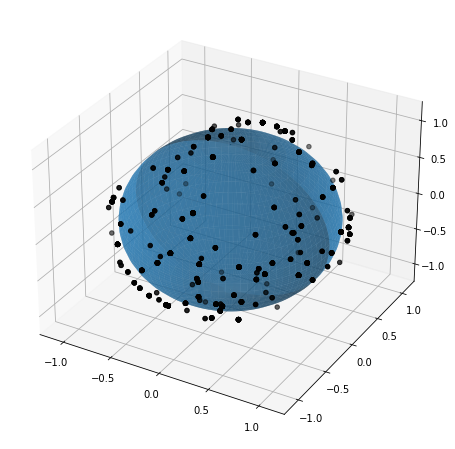

In [215]:
plot_angles(angles[:1000])

In [220]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))

In [221]:
with mrcfile.new('../data/reconstruction_simulated.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

## Optimization with respect to volume

### CG - applied to two halves of the data

In [ ]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 500

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

In [44]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

Iter 0 ||r|| = 3.6673661162194686
Iter 50 ||r|| = 0.00239441502354178
Iter 100 ||r|| = 0.0014497159102990792
Iter 150 ||r|| = 0.0010904046425069217
Iter 200 ||r|| = 0.0010258199725978049
Iter 250 ||r|| = 0.0009167498100917144
Iter 300 ||r|| = 0.0007776163930236651
Iter 350 ||r|| = 0.0008209748761078289
Iter 400 ||r|| = 0.0007481282731806708
Iter 450 ||r|| = 0.0005437064720964146


In [45]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.2710619728748439
Absolute error =  120.17798571937608


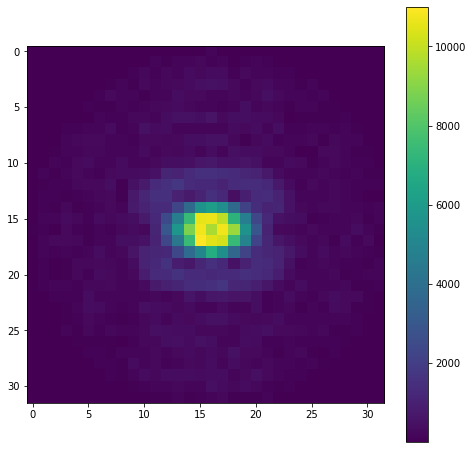

In [46]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

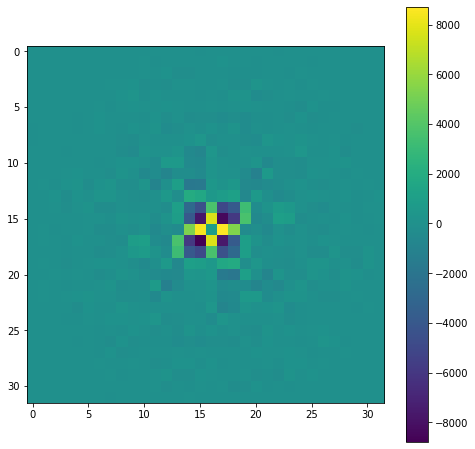

In [47]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

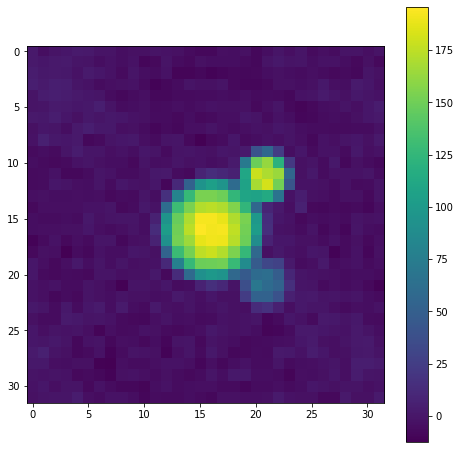

In [48]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

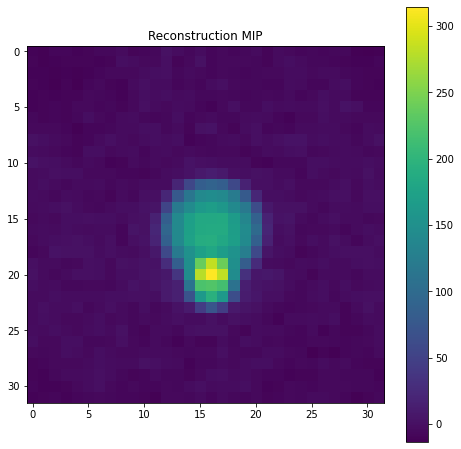

In [49]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

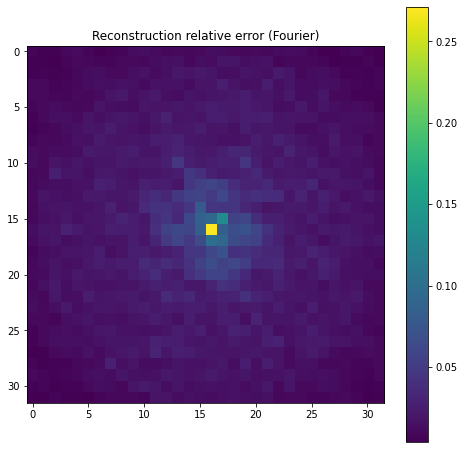

In [50]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

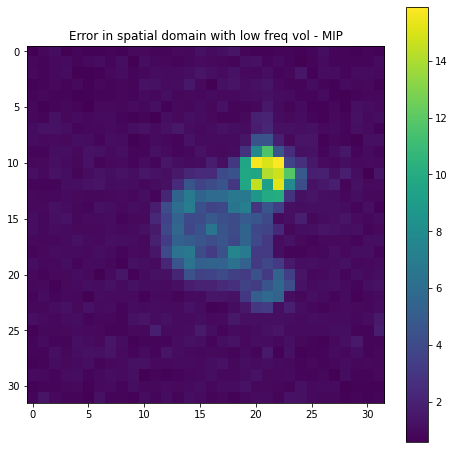

In [51]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [52]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [53]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [54]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

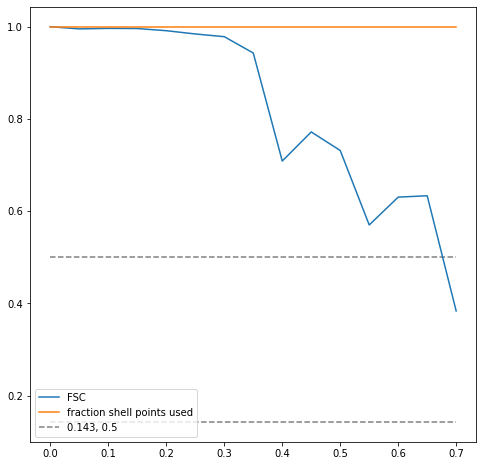

In [55]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

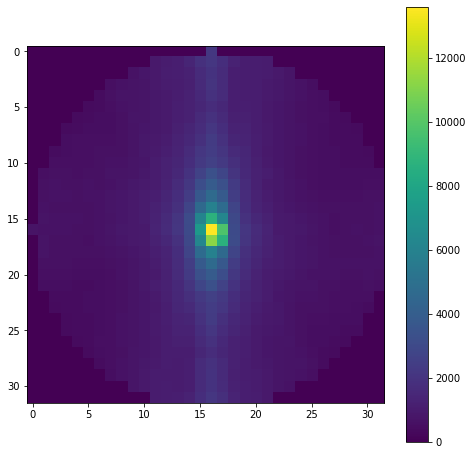

In [56]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [61]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [62]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

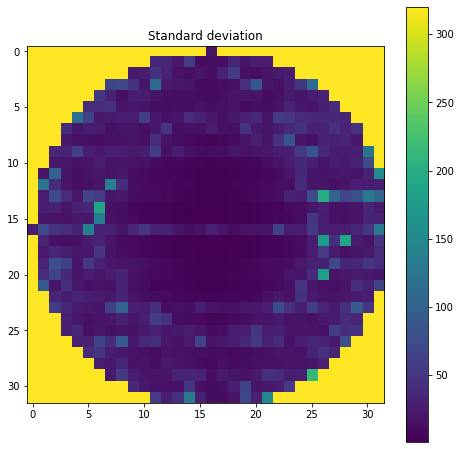

In [65]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

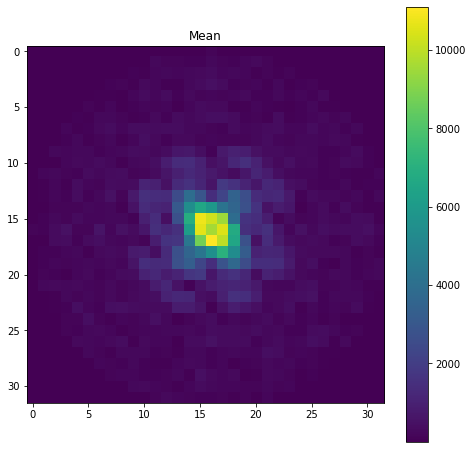

In [66]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [67]:
res

DeviceArray([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45,
             0.5 , 0.55, 0.6 , 0.65, 0.7 ], dtype=float64)

In [68]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

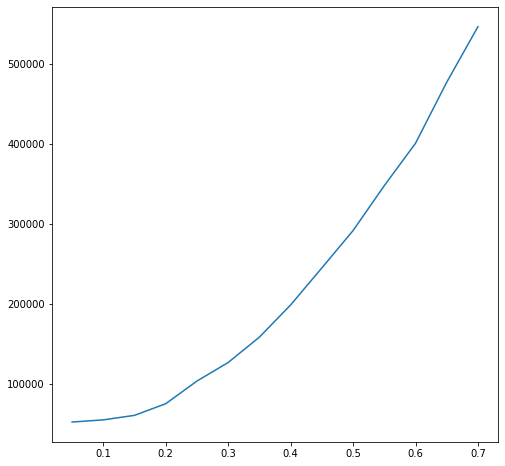

In [69]:
plt.plot(res[1:], loss)

### SGD

In [57]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 1001713.5331356218
Iter 100: mean loss = 979373.0191600893
Iter 200: mean loss = 962478.9227441741
Iter 300: mean loss = 917373.7779404835
Iter 400: mean loss = 938730.5705517398
Iter 500: mean loss = 938184.1541027596
Iter 600: mean loss = 917974.2442591009
Iter 700: mean loss = 895678.5689879379
Iter 800: mean loss = 884502.3844488263
Iter 900: mean loss = 891945.7813406892
Final loss function (over all data) =  886204.303726012
Relative error =  0.836066021390852


In [58]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  886204.303726012
Relative error =  0.836066021390852


Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

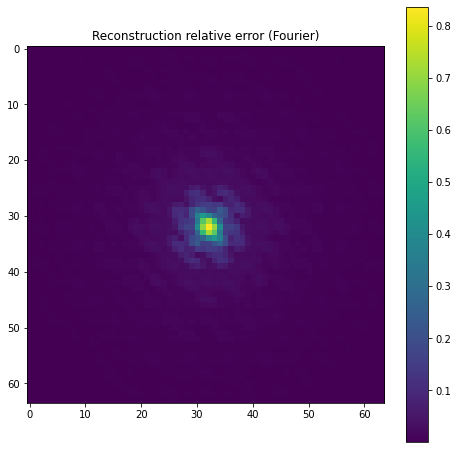

In [59]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

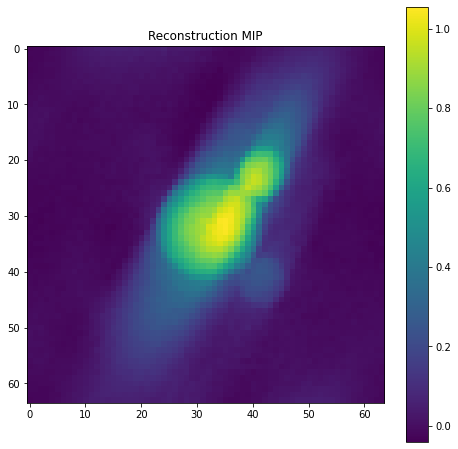

In [60]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

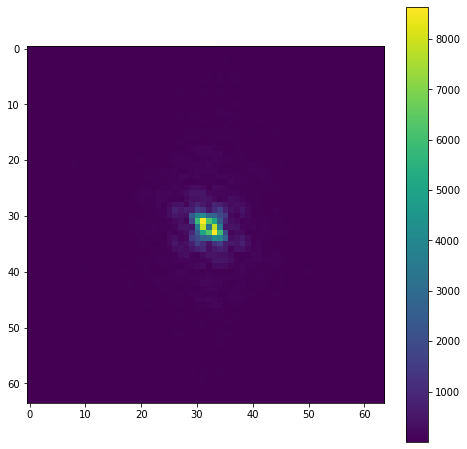

In [61]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

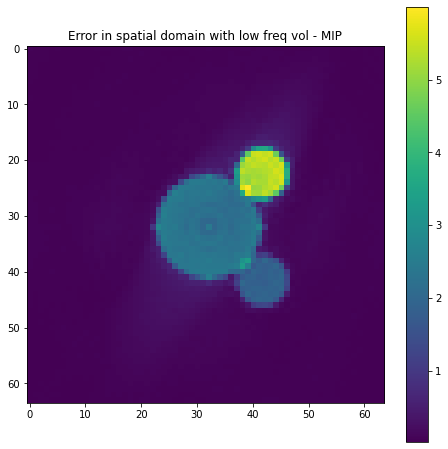

In [62]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

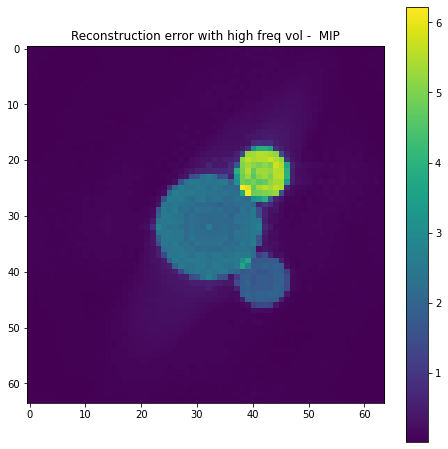

In [63]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

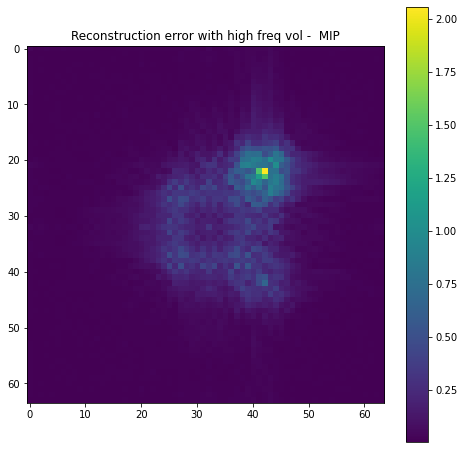

In [64]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')